In [14]:
import sys
import os

# Get the absolute path to the root directory where UQ_toolbox.py is located
root_dir = os.path.abspath(os.path.join(os.path.dirname('medMNIST'), '..'))
sys.path.append(root_dir)

In [15]:
import medmnist
from medmnist import INFO
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision.transforms as transforms
import numpy as np
from torchvision.models import resnet18
import random
from torchvision.utils import save_image
import os
import pickle as pkl
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import StratifiedKFold
from scipy.ndimage import zoom
import UQ_toolbox as uq
import torchvision.transforms.functional as TF
from matplotlib.patches import PathPatch, FancyBboxPatch
from matplotlib.path import Path
import torch.nn.functional as F
import matplotlib.patheffects as path_effects

In [16]:
# Define ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights='DEFAULT')
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

In [17]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
num_classes = len(info['label'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

test_dataset = DataClass(split='test', download=download, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

train_dataset = DataClass(split='train', download=download, transform=transform)
val_dataset = DataClass(split='val', download=download, transform=transform)

# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Set the random seed for reproducibility
torch.manual_seed(42)

# Calculate the sizes for training and calibration datasets
train_size = int(0.8 * len(combined_train_dataset))
calibration_size = len(combined_train_dataset) - train_size

# Split the combined_train_dataset into training and calibration datasets
train_dataset, calibration_dataset = random_split(combined_train_dataset, [train_size, calibration_size])

# Create DataLoaders for the new training and calibration datasets
calibration_loader = DataLoader(dataset=calibration_dataset, batch_size=128, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calibration_dataset)}')


# Create stratified K-fold cross-validator
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the labels for stratification
labels = [label for _, label in train_dataset]

# Create a list to store the new dataloaders
train_loaders = []
val_loaders = []

for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
    train_subset = torch.utils.data.Subset(train_dataset, train_index)
    val_subset = torch.utils.data.Subset(train_dataset, val_index)
    
    train_loader = DataLoader(dataset=train_subset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=128, shuffle=True, drop_last=True)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

Training dataset size: 32841
Calibration dataset size: 8211


In [5]:
# Set the seed for reproducibility
random.seed(123)

# Get 5 random indices
random_indices = random.sample(range(len(test_dataset)), 15)

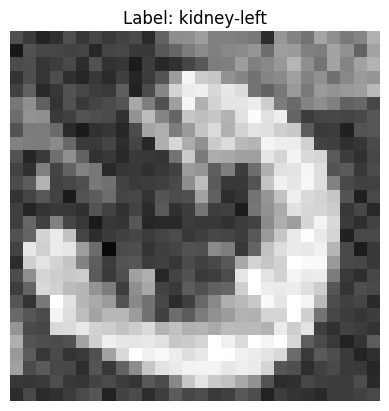

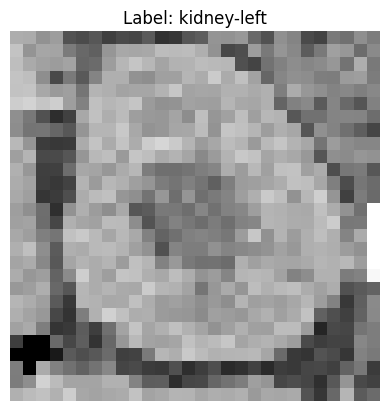

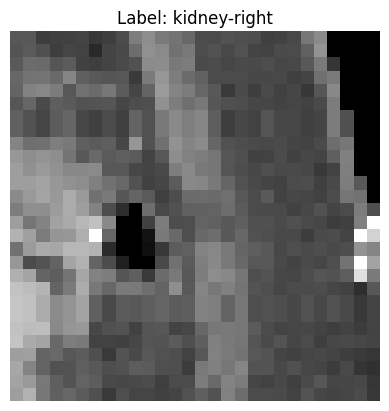

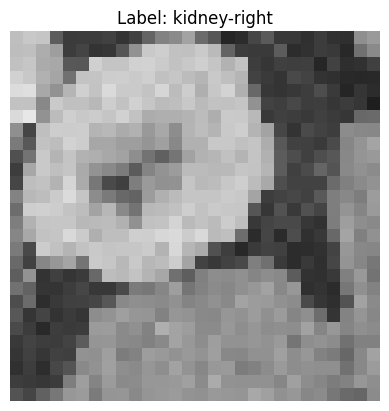

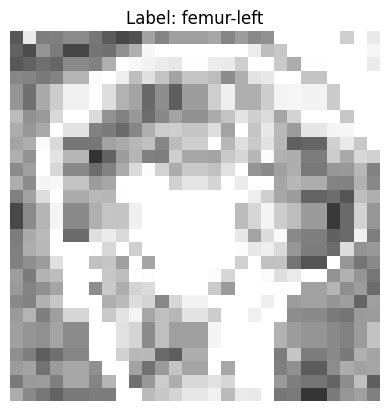

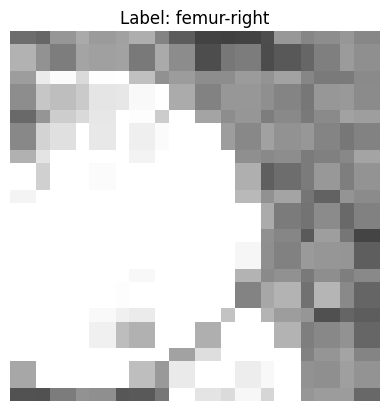

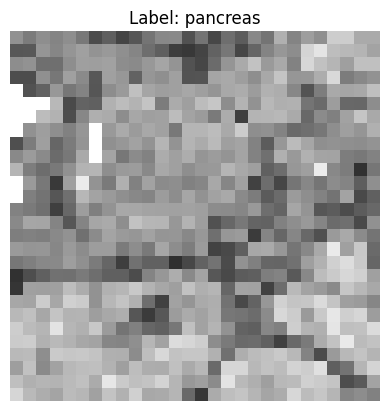

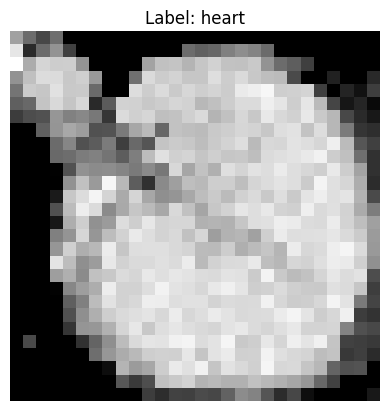

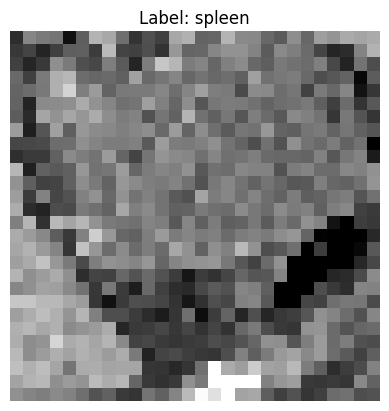

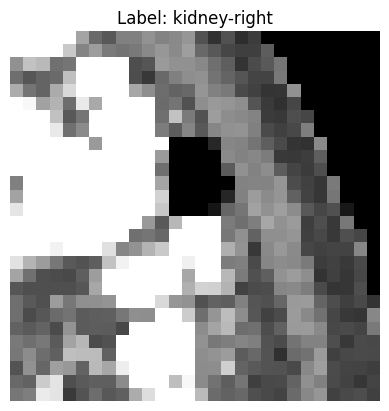

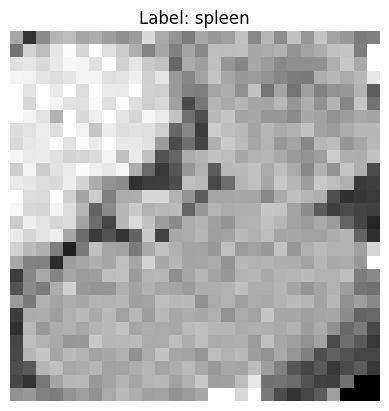

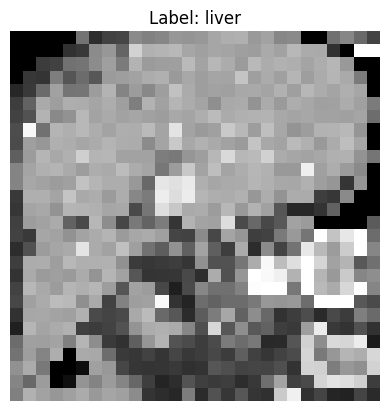

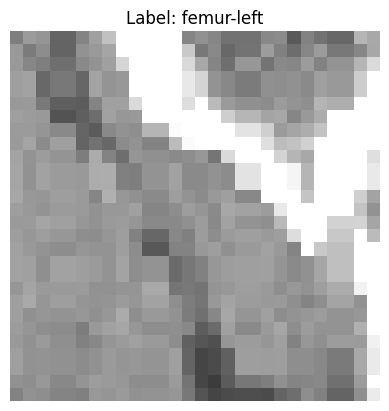

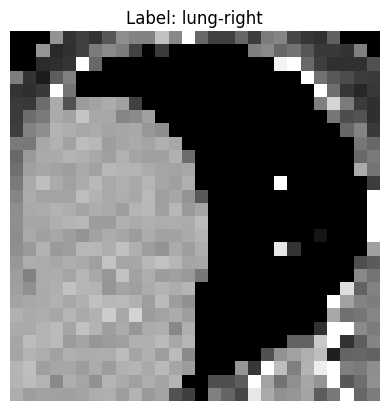

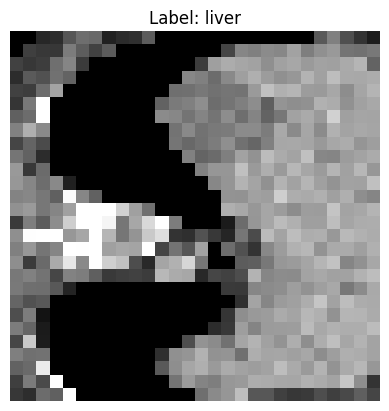

In [6]:
# Create a directory to save the images
os.makedirs("random_images", exist_ok=True)


# Display and save the images
for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title(f"Label: {info['label'][str(label.item())]}")
    plt.axis("off")
    plt.show()
    
    # Save the image
    save_image(image, f"random_images/image_{i}_label_{label}.png")

In [8]:
# Load saved models
models = []
for i in range(5):
    model = ResNet18(num_classes=num_classes)
    model.load_state_dict(torch.load(f'resnet18_organamnist{i}.pt'))
    model = model.to(device)
    model.eval()
    models.append(model)

In [9]:
# Compute uncertainty for all test samples
uncertainty_scores = []
# Perform inference on the test set
y_true = []
y_scores = []
indiv_scores = [[], [], [], [], []]

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = [model(data) for model in models]
        for ind, output in zip(indiv_scores, outputs):
            ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
            
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        y_true.extend(target.cpu().numpy().flatten())
        y_scores.extend(avg_output.cpu().numpy())

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))
uncertainty = uq.distance_to_hard_labels_computation(y_prob)


/tmp/ipykernel_929113/3934560096.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  ind.extend(np.array(F.softmax(torch.tensor(output.cpu().numpy()), dim=1)))
/tmp/ipykernel_929113/3934560096.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_prob = np.array(F.softmax(torch.tensor(y_scores), dim=1))


In [10]:
# Sort uncertainty scores and get the indices
sorted_indices = np.argsort(uncertainty)

# Select 10 low UQ cases and 10 high UQ cases
selected_indices = list(sorted_indices[:10]) + list(sorted_indices[-10:])

# Shuffle the selected indices
random.shuffle(selected_indices)

# Create a directory to save the images
os.makedirs("selected_uq_images", exist_ok=True)

# Save the selected images
for i, idx in enumerate(selected_indices):
    image, label = test_dataset[idx]
    save_image(image, f"selected_uq_images/image_{i}_label_{label}.png")

In [11]:
# Define a function to register hooks and capture outputs
def register_hooks(model, layers):
    outputs = {}

    def hook_fn(module, input, output):
        outputs[module] = output

    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(hook_fn))
    return outputs, hooks

# Define the layers to capture
layers_to_capture = [
    model.model.layer1,
    model.model.layer2,
    model.model.layer3,
    model.model.layer4
]

# Register hooks
layer_outputs, hooks = register_hooks(model, layers_to_capture)


In [12]:
info = {
    '0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left',
    '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'
}

KeyError: '0'

Error in callback <function _draw_all_if_interactive at 0x7e7540a50c20> (for post_execute), with arguments args (),kwargs {}:


KeyError: '0'

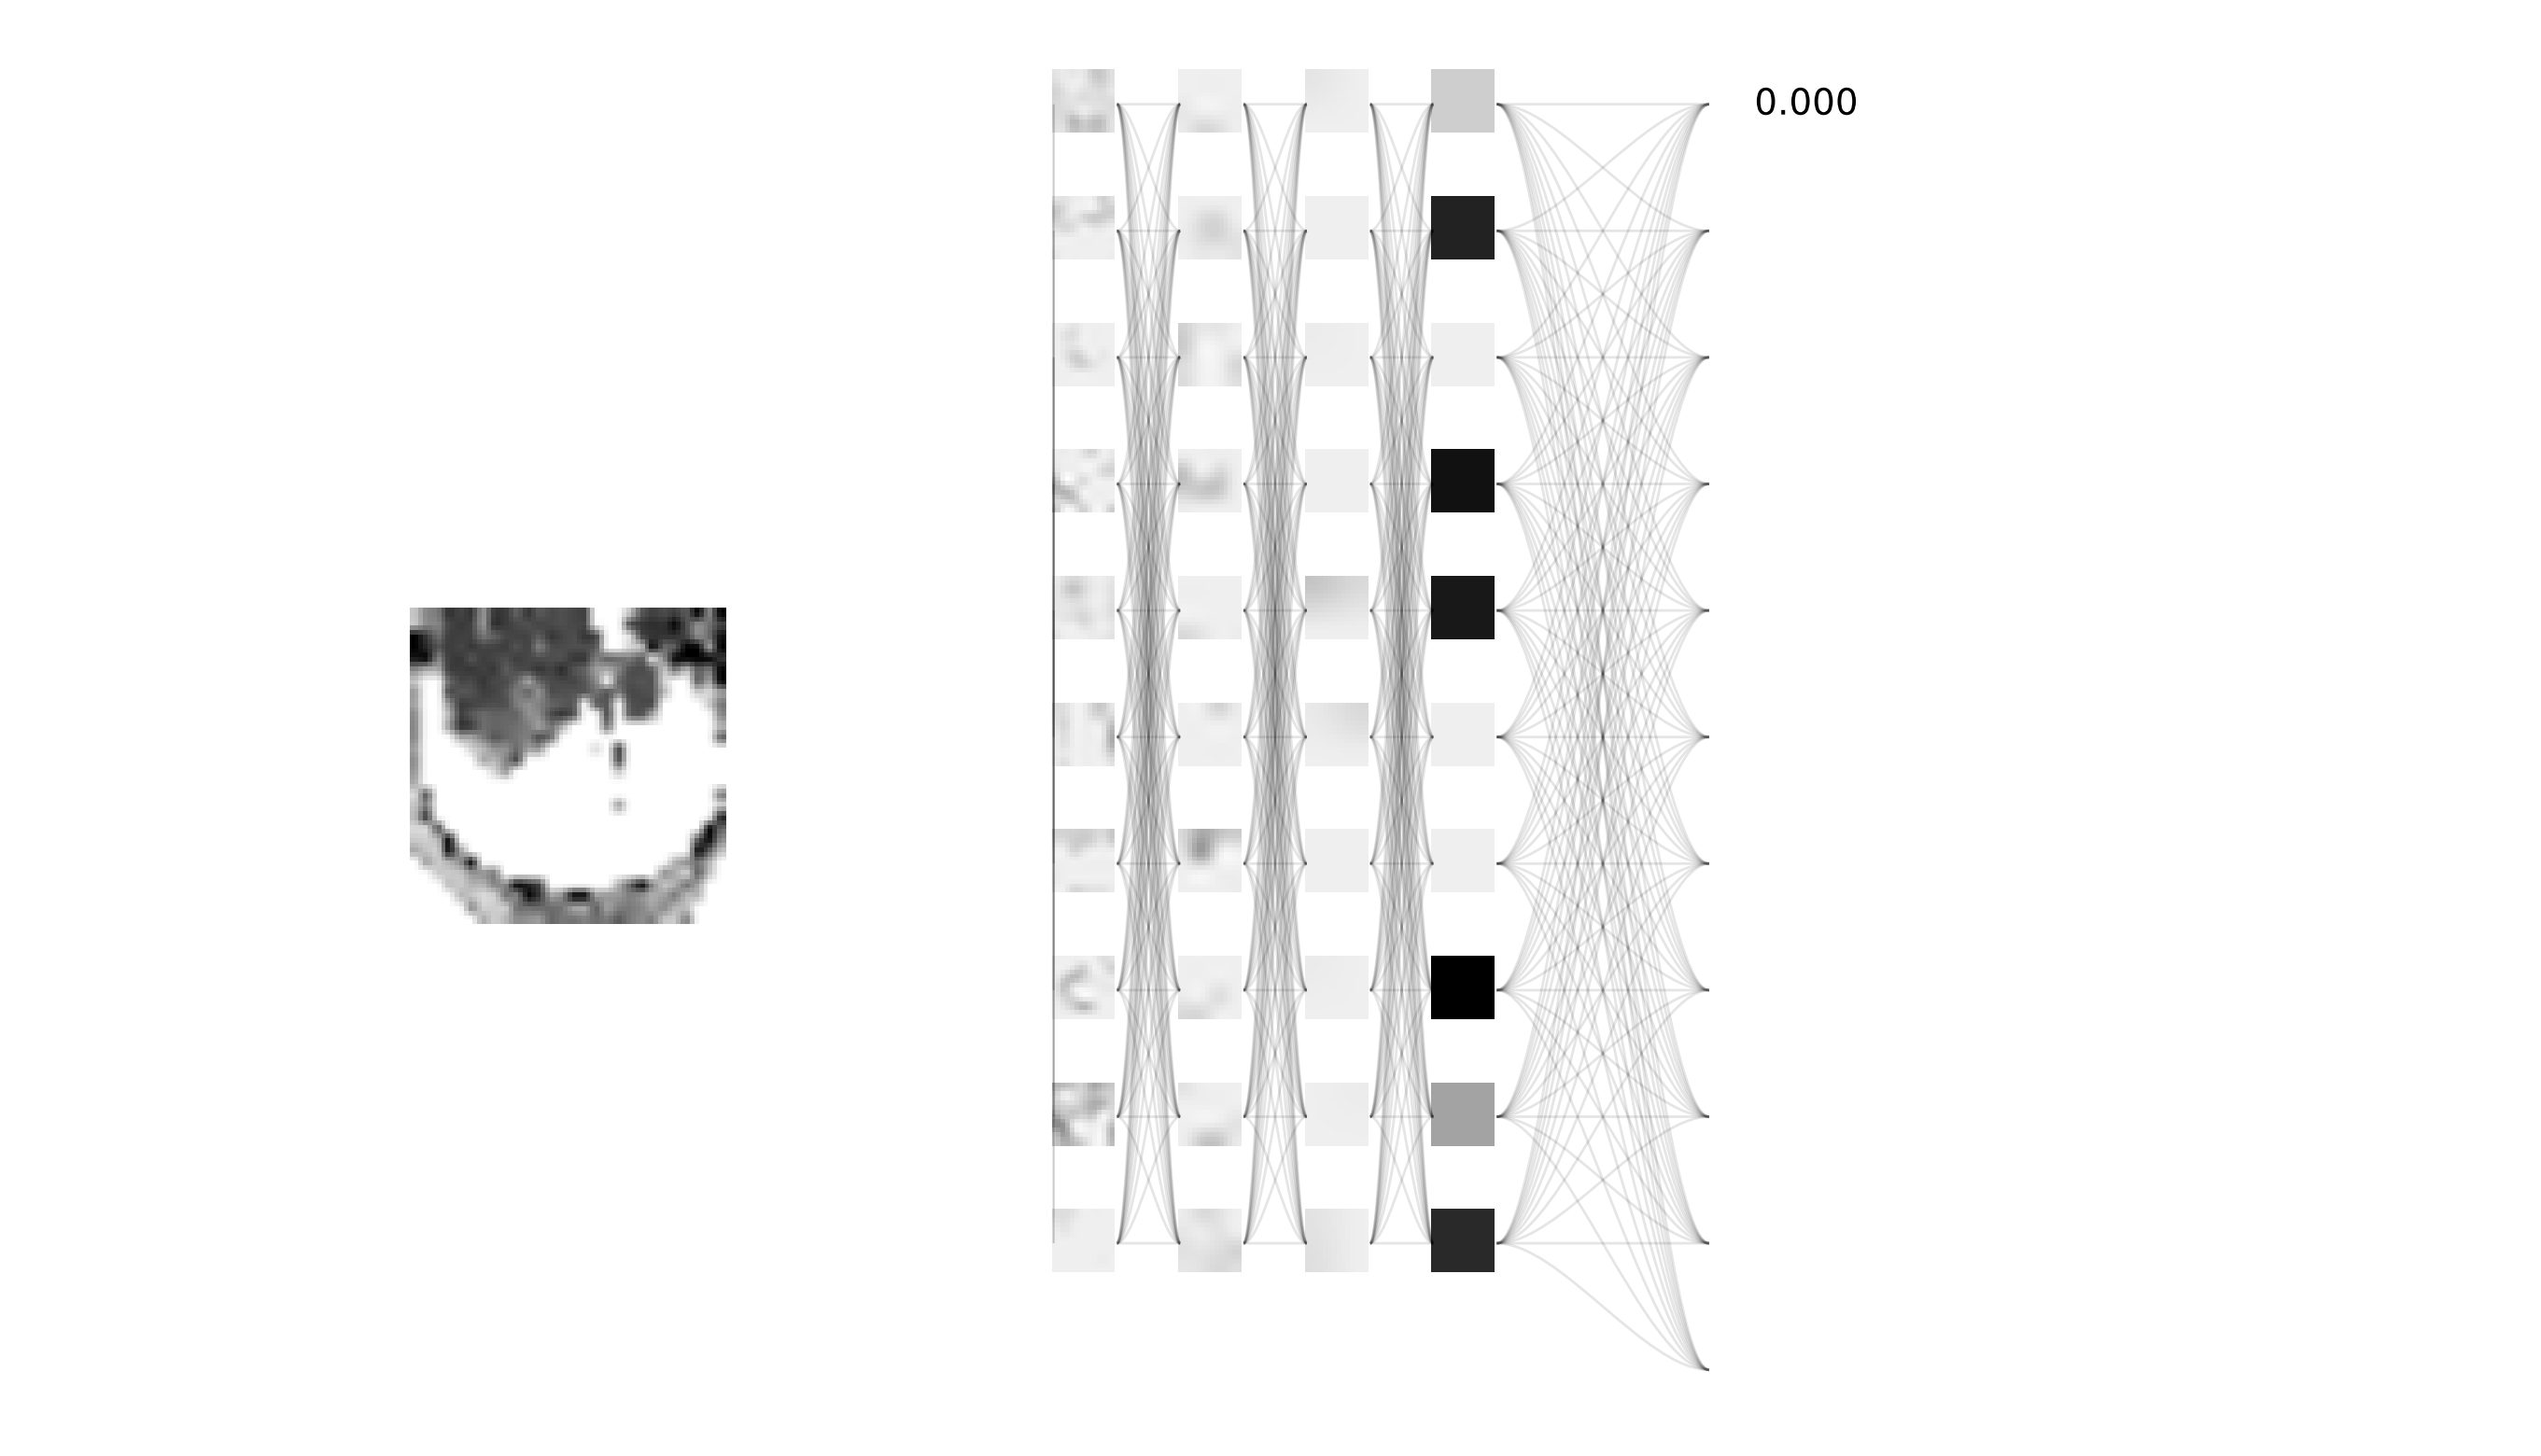

In [ ]:
# MSR

combined_outputs = []
layer_filter_positions_per_frame = []
image_centers_per_frame = []
softmax_digit_positions_per_frame = []
label_text_positions_per_frame = []
num_frames = None

for i in range(20):
    combined_lay = []
    sample_image, _ = test_dataset[selected_indices[i]]
    sample_image = sample_image.unsqueeze(0).to(device)

    target_size = (14, 14)
    for lay in range(4):
        combined_frames = []
        layer_outputs, hooks = register_hooks(model, layers_to_capture)
        _ = model(sample_image)

        for output in layer_outputs[list(layer_outputs)[lay]]:
            output = output.squeeze(0).cpu().detach().numpy()
            if num_frames is None:
                num_frames = 10

            resized_output = np.array([
                zoom(frame, (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1]))
                for frame in output
            ])
            combined_frames.append(resized_output)

        frames = np.vstack([
            np.vstack([
                combined_frames[0][frame],
                np.full((combined_frames[0][frame].shape[0], combined_frames[0][frame].shape[0]), -0.46953085064888)
            ])
            for frame in range(num_frames)
        ])
        combined_lay.append(frames)

    final_lay = np.hstack([
        np.hstack([
            combined_lay[layer],
            np.full((combined_lay[layer].shape[0], combined_lay[layer].shape[1]), -0.46953085064888)
        ])
        for layer in range(4)
    ])

    final_height = final_lay.shape[0]
    resized_height = final_height // 4
    orig_pil = TF.to_pil_image(sample_image.squeeze(0).cpu())
    orig_resized = TF.resize(orig_pil, size=(resized_height, resized_height))
    orig_image_np = np.array(orig_resized).astype(np.float32)

    if orig_image_np.ndim == 3:
        orig_image_np = np.mean(orig_image_np, axis=2)

    orig_image_np = (orig_image_np - orig_image_np.min()) / (orig_image_np.max() - orig_image_np.min())
    orig_image_np = orig_image_np * (np.max(final_lay) - (-0.46953085064888)) + (-0.46953085064888)

    extra_top = int(final_height * 0.05)
    top_pad = (final_height - resized_height) // 2 + extra_top
    bottom_pad = final_height - resized_height - top_pad
    pad_width = int(final_lay.shape[1] * 0.65)

    orig_image_padded = np.pad(
        orig_image_np,
        ((top_pad, bottom_pad), (pad_width, pad_width)),
        constant_values=-0.46953085064888
    )

    with torch.no_grad():
        logits = model(sample_image)
        probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()

    final_frame = np.hstack([
        orig_image_padded,
        final_lay,
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888),
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888)
    ])

    softmax_digit_positions = []
    label_text_positions = []
    for idx in range(11):
        y = idx * target_size[0] * 2 + target_size[0] // 2
        x = final_frame.shape[1] + 5
        softmax_digit_positions.append((x, y))
        label_text_positions.append((x + 35, y))  # reduced spacing here

    pad_y = int(0.05 * final_frame.shape[0])
    pad_x = int(0.05 * final_frame.shape[1])
    final_frame = np.pad(
        final_frame,
        ((pad_y, pad_y), (pad_x, pad_x)),
        constant_values=-0.46953085064888
    )
    combined_outputs.append(final_frame)
    softmax_digit_positions_per_frame.append([(x + pad_x, y + pad_y) for (x, y) in softmax_digit_positions])
    label_text_positions_per_frame.append([(x + pad_x, y + pad_y) for (x, y) in label_text_positions])

    layer_positions = []
    x_offset = orig_image_padded.shape[1]
    for layer in combined_lay:
        x_center = x_offset + target_size[1] // 2
        y_centers = [f * target_size[0] * 2 + target_size[0] // 2 for f in range(num_frames)]
        layer_positions.append([(x_center + pad_x, y + pad_y) for y in y_centers])
        x_offset += target_size[1] * 2

    image_center = (orig_image_padded.shape[1] // 2 + pad_x, final_height // 2 + pad_y)
    layer_filter_positions_per_frame.append(layer_positions)
    image_centers_per_frame.append(image_center)

fig, ax = plt.subplots(figsize=(40, 20))
connection_patches = []
first_frame_layers = layer_filter_positions_per_frame[0]
first_softmax_positions = softmax_digit_positions_per_frame[0]
filter_half_width = target_size[1] // 2

for dest in first_frame_layers[0]:
    src_x = int(orig_image_padded.shape[1] / 1.5)
    src_y = image_centers_per_frame[0][1]
    src = (src_x + pad_x, src_y)
    dst = (dest[0] - filter_half_width, dest[1])
    ctrl1 = (src[0] + (dst[0] - src[0]) * 0.3, src[1])
    ctrl2 = (src[0] + (dst[0] - src[0]) * 0.7, dst[1])
    path = Path([src, ctrl1, ctrl2, dst], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.2))

for l in range(len(first_frame_layers) - 1):
    src_layer = first_frame_layers[l]
    dst_layer = first_frame_layers[l + 1]
    for src in src_layer:
        for dst in dst_layer:
            src_pos = (src[0] + filter_half_width, src[1])
            dst_pos = (dst[0] - filter_half_width, dst[1])
            ctrl1 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.3, src_pos[1])
            ctrl2 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.7, dst_pos[1])
            path = Path([src_pos, ctrl1, ctrl2, dst_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
            connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=2.0, alpha=0.1))

last_layer = first_frame_layers[-1]
for src in last_layer:
    for dst in first_softmax_positions:
        src_pos = (src[0] + filter_half_width, src[1])
        dst_pos = dst
        ctrl1 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.3, src_pos[1])
        ctrl2 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.7, dst_pos[1])
        path = Path([src_pos, ctrl1, ctrl2, dst_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=2.0, alpha=0.1))

# --- ANIMATION ---
def update(frame_idx):
    ax.clear()
    # Add this after ax.clear() in the update function
    ax.set_xlim(0, combined_outputs[frame_idx].shape[1] + 170)
    ax.set_ylim(combined_outputs[frame_idx].shape[0] +10, 0)  # Invert y-axis for image coordinates
    ax.imshow(combined_outputs[frame_idx], cmap='gray_r', vmin=-0.46953085064888, vmax=np.max(combined_outputs[frame_idx]))
    ax.axis('off')

    for patch in connection_patches:
        ax.add_patch(patch)

    with torch.no_grad():
        softmax_values = F.softmax(model(test_dataset[selected_indices[frame_idx]][0].unsqueeze(0).to(device)), dim=1).squeeze().detach().cpu().numpy()
        distance = uq.distance_to_hard_labels_computation(softmax_values)
        
    # Add softmax probabilities and labels
    for idx, prob in enumerate(softmax_values):
        x, y = softmax_digit_positions_per_frame[frame_idx][idx]
        ax.text(x + 10, y, f"{prob:.3f}", ha='left', va='center', fontsize=28, color='black',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

        lx, ly = label_text_positions_per_frame[frame_idx][idx]
        ax.text(lx + 5, ly, info[str(idx)], ha='left', va='center', fontsize=35, color='black',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])

    # Highlight the top prediction
    top_idx = int(softmax_values.argmax())
    x, y = softmax_digit_positions_per_frame[frame_idx][top_idx]
    lx, _ = label_text_positions_per_frame[frame_idx][top_idx]
    box_width = lx - x + 65
    rect = FancyBboxPatch((x + 5, y - target_size[0]), box_width, target_size[0] * 2,
                          boxstyle="round,pad=0.3", edgecolor='black', linewidth=3, facecolor='none')
    ax.add_patch(rect)
    
    # Add Max Softmax Response (MSR) bar plot
    msr_ax = fig.add_axes([0.85, 0.3, 0.1, 0.4])  # Adjust position and size of the bar plot
    msr_ax.bar(0, distance, 0.05)#, edgecolor='black')
    msr_ax.set_xlim(-0.06, 0.06)
    msr_ax.set_ylim(0, 1)
    msr_ax.set_xlabel("Max Softmax Response", fontsize=35, labelpad=20)
    msr_ax.tick_params(axis='y', which='major', labelsize=30)
    msr_ax.set(xticklabels=[])
    msr_ax.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Add connection patch between circled label and bar plot
    label_pos = (x + box_width + 5, y)  # Position of the circled label
    bar_pos = (combined_outputs[frame_idx].shape[1] + 150, msr_ax.get_position().y0 * combined_outputs[frame_idx].shape[0] + 65)  # Approximate bar plot position
    ctrl1 = (label_pos[0] + (bar_pos[0] - label_pos[0]) * 0.3, label_pos[1])
    ctrl2 = (label_pos[0] + (bar_pos[0] - label_pos[0]) * 0.7, bar_pos[1])
    path = Path([label_pos, ctrl1, ctrl2, bar_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    connection_patch = PathPatch(path, facecolor='none', edgecolor='black', lw=2, alpha=0.8)
    ax.add_patch(connection_patch)

ani = FuncAnimation(fig, update, frames=20, interval=1000)
ani.save('layer_output_resized_comb_layers_MSR.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)


In [19]:
# --- ENSEMBLING ILLUSTRATION ---
fig, ax = plt.subplots(figsize=(20, 10))

# --- ANIMATION ---
def update_ensembling(frame_idx):
    ax.clear()
    ax.set_xlim(-10, 16)  # Adjust x-axis to fit the image and digits
    ax.set_ylim(-1, 6)  # 5 models (lines) + 1 row for standard deviation
    ax.axis('off')

    # Display the original image on the left
    sample_image, _ = test_dataset[selected_indices[frame_idx]]
    ax.imshow(sample_image.permute(1, 2, 0).squeeze(), cmap="gray", extent=[-10, -5, 0, 5])

    # Get the softmax probabilities for the current frame
    with torch.no_grad():
        softmax_values_per_model = [
            F.softmax(model(sample_image.unsqueeze(0).to(device)), dim=1).squeeze().cpu().numpy()
            for model in models
        ]

    # Compute standard deviation for each class across models
    softmax_values_array = np.array(softmax_values_per_model)  # Shape: (num_models, num_classes)
    std_devs = np.std(softmax_values_array, axis=0)

    # Display the softmax probabilities as digits
    for model_idx, softmax_values in enumerate(softmax_values_per_model):
        y_position = 5 - model_idx  # Line position for each model
        for class_idx, prob in enumerate(softmax_values):
            x_position = class_idx + 1  # Offset for class positions
            ax.text(x_position, y_position, f"{prob:.2f}", ha='center', va='center', fontsize=12)

    # Add a new row for standard deviation values
    y_position = 0  # Position for the standard deviation row
    for class_idx, std_dev in enumerate(std_devs):
        x_position = class_idx + 1  # Offset for class positions
        ax.text(x_position, y_position, f"{std_dev:.2f}", ha='center', va='center', fontsize=12, color='red')

    # Add connections from the original image to the softmax digits
    for model_idx in range(len(softmax_values_per_model)):
        src_x = -5  # End of the original image
        src_y = 2.5  # Vertical center of the original image
        dst_x = -2  # Stop even earlier before the digits line
        dst_y = 5 - model_idx  # Line position for each model

        # Create a curved connector
        ctrl1 = (src_x + (dst_x - src_x) * 0.3, src_y)
        ctrl2 = (src_x + (dst_x - src_x) * 0.7, dst_y)
        path = Path([ (src_x, src_y), ctrl1, ctrl2, (dst_x, dst_y) ], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connector = PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
        ax.add_patch(connector)

    # Add a connector from the end of column 11 (line 6) to the bar plot
    std_src_x = 11.5  # End of column 11
    std_src_y = 0  # Line 6
    bar_dst_x = 13  # Middle of the bar plot
    bar_dst_y = 2.5  # Vertical center of the bar plot

    # Create a curved connector for the 11th column
    ctrl1 = (std_src_x + (bar_dst_x - std_src_x) * 0.3, std_src_y)
    ctrl2 = (std_src_x + (bar_dst_x - std_src_x) * 0.7, bar_dst_y)
    path = Path([ (std_src_x, std_src_y), ctrl1, ctrl2, (bar_dst_x, bar_dst_y) ], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    std_connector = PathPatch(path, facecolor='none', edgecolor='red', lw=2, alpha=0.8)
    ax.add_patch(std_connector)

    # Add a bar plot for the mean of standard deviations
    mean_std_dev = np.mean(std_devs)
    bar_ax = fig.add_axes([0.85, 0.3, 0.1, 0.4])  # Position and size of the bar plot
    bar_ax.bar(0, mean_std_dev, 0.05)
    bar_ax.set_xlim(-0.06, 0.06)
    bar_ax.set_ylim(0, 0.2)
    bar_ax.set_xticks([])
    bar_ax.set_xlabel("Mean std dev ensembling", fontsize=14, labelpad=10)
    bar_ax.tick_params(axis='y', labelsize=12)
    bar_ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add class names as a single line above the table
    class_names = [info['label'][str(i)] for i in range(11)]  # Extract class names from the `info['label']` dictionary
    for class_idx, class_name in enumerate(class_names):
        x_position = class_idx + 1  # Offset for class positions
        ax.text(x_position, 6, class_name, ha='center', va='center', fontsize=12, color='black')  # Position above the table

ani = FuncAnimation(fig, update_ensembling, frames=20, interval=1000)
ani.save('ensembling_softmax_results.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)

In [39]:
from torchvision.transforms import RandAugment

# --- TTA ILLUSTRATION ---
fig, ax = plt.subplots(figsize=(20, 10))

# Define RandAugment transformation
rand_augment = RandAugment(num_ops=2, magnitude=20)

# --- ANIMATION ---
def update_tta(frame_idx):
    ax.clear()
    ax.set_xlim(-10, 16)  # Adjust x-axis to fit the image and digits
    ax.set_ylim(-1, 6)  # 5 augmentations (lines) + 1 row for standard deviation
    ax.axis('off')

    # Display the original image on the left
    sample_image, _ = test_dataset[selected_indices[frame_idx]]
    ax.imshow(sample_image.permute(1, 2, 0).squeeze(), cmap="gray", extent=[-10, -5, 0, 5])

    # Convert the sample image to uint8 before applying RandAugment
    sample_image_uint8 = (sample_image * 255).byte()
    
    # Generate 5 augmentations of the original image
    augmented_images = [rand_augment(sample_image_uint8).float().div(255) for _ in range(5)]

    # Define padding between the original image and augmentations
    horizontal_padding = -2  # Padding between the original image and augmentations
    vertical_padding = 0.1#0.5  # Padding between augmentations

    # Display the augmentations as a column with padding
    for i, aug_image in enumerate(augmented_images):
        ax.imshow(
            aug_image.permute(1, 2, 0).squeeze(),
            cmap="gray",
            extent=[
                -5 - horizontal_padding,  # Add horizontal padding
                -4 - horizontal_padding,
                5 - i - i * vertical_padding,  # Add vertical padding
                4 - i - i * vertical_padding
            ]
        )

    # Get the softmax probabilities for the current frame using model 0
    with torch.no_grad():
        softmax_values_per_augmentation = [
            F.softmax(models[0](aug_image.unsqueeze(0).to(device)), dim=1).squeeze().cpu().numpy()
            for aug_image in augmented_images
        ]

    # Compute standard deviation for each class across augmentations
    softmax_values_array = np.array(softmax_values_per_augmentation)  # Shape: (num_augmentations, num_classes)
    std_devs = np.std(softmax_values_array, axis=0)

    # Display the softmax probabilities as digits
    for aug_idx, softmax_values in enumerate(softmax_values_per_augmentation):
        y_position = 5 - aug_idx - aug_idx * vertical_padding  # Match y positions with padding
        for class_idx, prob in enumerate(softmax_values):
            x_position = class_idx + 1  # Offset for class positions
            ax.text(x_position, y_position, f"{prob:.2f}", ha='center', va='center', fontsize=12)

    # Add a new row for standard deviation values
    y_position = -1  # Position for the standard deviation row
    for class_idx, std_dev in enumerate(std_devs):
        x_position = class_idx + 1  # Offset for class positions
        ax.text(x_position, y_position, f"{std_dev:.2f}", ha='center', va='center', fontsize=12, color='red')

    # Update connectors to account for the padding
    for aug_idx in range(len(augmented_images)):
        src_x = -5  # Start at the end of the original image
        src_y = 2.5  # Vertical center of the original image
        dst_x = -5 - horizontal_padding  # Stop at the beginning of the augmented image
        dst_y = 4.5 - aug_idx - aug_idx * vertical_padding  # Adjust destination y-coordinate for vertical padding

        # Create a curved connector
        ctrl1 = (src_x + (dst_x - src_x) * 0.3, src_y)
        ctrl2 = (src_x + (dst_x - src_x) * 0.7, dst_y)
        path = Path([(src_x, src_y), ctrl1, ctrl2, (dst_x, dst_y)], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connector = PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
        ax.add_patch(connector)

    # Update connectors to link augmented images to the corresponding lines
    for aug_idx in range(len(augmented_images)):
        src_x = horizontal_padding  # Start at the end of the augmented image
        src_y = 4.5 - aug_idx - aug_idx * vertical_padding  # Vertical center of the augmented image
        dst_x = 0.5  # Stop at the beginning of the corresponding line
        dst_y = 5 - aug_idx - aug_idx * vertical_padding  # Line position for each augmentation

        # Create a curved connector
        ctrl1 = (src_x + (dst_x - src_x) * 0.3, src_y)
        ctrl2 = (src_x + (dst_x - src_x) * 0.7, dst_y)
        path = Path([(src_x, src_y), ctrl1, ctrl2, (dst_x, dst_y)], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
        connector = PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
        ax.add_patch(connector)
    
    # Add a connector from the end of column 11 (line 6) to the bar plot
    std_src_x = 11.5  # End of column 11
    std_src_y = -0.9  # Line 6
    bar_dst_x = 13  # Middle of the bar plot
    bar_dst_y = 2.5  # Vertical center of the bar plot
    # Create a curved connector for the 11th column
    ctrl1 = (std_src_x + (bar_dst_x - std_src_x) * 0.3, std_src_y)
    ctrl2 = (std_src_x + (bar_dst_x - std_src_x) * 0.7, bar_dst_y)
    path = Path([ (std_src_x, std_src_y), ctrl1, ctrl2, (bar_dst_x, bar_dst_y) ], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    std_connector = PathPatch(path, facecolor='none', edgecolor='red', lw=2, alpha=0.8)
    ax.add_patch(std_connector)

    # Add a bar plot for the mean of standard deviations
    mean_std_dev = np.mean(std_devs)
    bar_ax = fig.add_axes([0.85, 0.3, 0.1, 0.4])  # Position and size of the bar plot
    bar_ax.bar(0, mean_std_dev, 0.05)
    bar_ax.set_xlim(-0.06, 0.06)
    bar_ax.set_ylim(0, 0.2)
    bar_ax.set_xticks([])
    bar_ax.set_xlabel("Mean std dev TTA", fontsize=14, labelpad=10)
    bar_ax.tick_params(axis='y', labelsize=12)
    bar_ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Ensure the last image is not cropped
    ax.set_ylim(-1 - vertical_padding, 6)  # Adjust ylim to include the last image

ani = FuncAnimation(fig, update_tta, frames=20, interval=1000)
ani.save('tta_softmax_results.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)

In [42]:
import matplotlib.animation as animation

# Define the figure and axes
fig, axes = plt.subplots(5, 6, figsize=(15, 10))

# Function to update the frames
def update(frame_idx):
    for col, idx in enumerate(selected_indices[:6]):
        # Load the original image
        image, _ = test_dataset[idx]
        
        # Display the augmented image
        for row in range(5):
            # Convert the image to uint8 and apply RandAugment
            image_uint8 = (image * 255).byte()
            augmented_image = rand_augment(image_uint8).float().div(255)
            ax = axes[row, col]
            ax.clear()
            ax.imshow(augmented_image.permute(1, 2, 0).squeeze(), cmap="gray")
            ax.axis("off")
            if row == 0:
                ax.set_title(f"Image {col+1}")
    
    plt.tight_layout()

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=6, interval=1000)

# Save the animation as a video
ani.save('augmented_images.mp4', writer='ffmpeg', fps=1, dpi=150)

plt.close(fig)

In [20]:
latent_space_training, labels_training, _, _ = uq.extract_latent_space_and_compute_shap_importance(models[0], train_loaders[0], device, models[0].model.avgpool, False, None)

In [28]:
from torch.utils.data import Subset

# Create a subset of the test dataset using the selected indices
selected_test_subset = Subset(test_dataset, selected_indices)

# Create a DataLoader for the subset
selected_test_loader = DataLoader(dataset=selected_test_subset, batch_size=32, shuffle=False)

# Print the size of the subset
print(f"Number of samples in the selected test subset: {len(selected_test_subset)}")

Number of samples in the selected test subset: 20


In [29]:
latent_space_test, labels_test, _, _ = uq.extract_latent_space_and_compute_shap_importance(models[0], selected_test_loader, device, models[0].model.avgpool, False, None)

/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


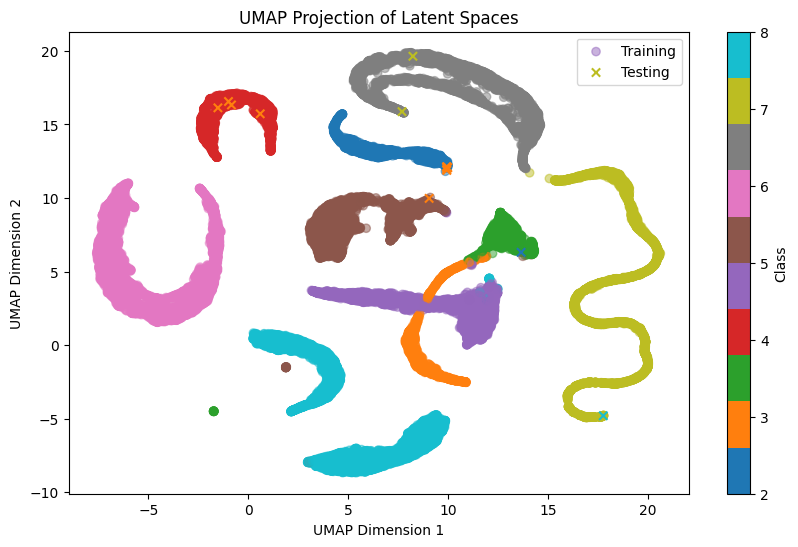

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the latent spaces
scaler = StandardScaler()
latent_space_training_std = scaler.fit_transform(latent_space_training.cpu().numpy())
latent_space_test_std = scaler.transform(latent_space_test.cpu().numpy())

# Perform PCA to retain 90% of variability
pca = PCA(n_components=0.90)
latent_space_training_pca = pca.fit_transform(latent_space_training_std)
latent_space_test_pca = pca.transform(latent_space_test_std)

# Perform UMAP in 2D
umap_reducer = umap.UMAP(n_components=2, random_state=42)
latent_space_training_umap = umap_reducer.fit_transform(latent_space_training_pca)
latent_space_test_umap = umap_reducer.transform(latent_space_test_pca)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(latent_space_training_umap[:, 0], latent_space_training_umap[:, 1], c=labels_training.flatten(), cmap='tab10', alpha=0.5, label='Training')
plt.scatter(latent_space_test_umap[:, 0], latent_space_test_umap[:, 1], c=labels_test.flatten(), cmap='tab10', marker='x', label='Testing')
plt.colorbar(label='Class')
plt.legend()
plt.title('UMAP Projection of Latent Spaces')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

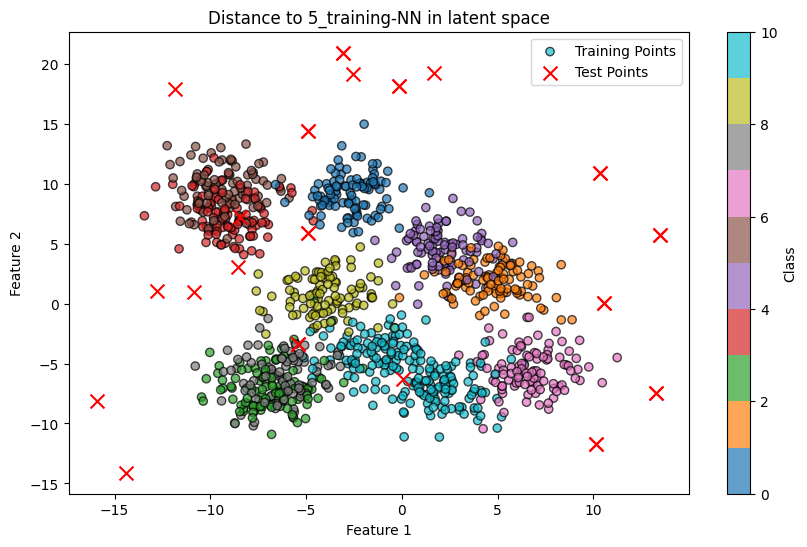

In [42]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

# Generate random data points for 11 classes
n_classes = 11
n_samples_per_class = 100
n_features = 2
random_state = 42

# Create blobs for each class
X, y = make_blobs(n_samples=n_classes * n_samples_per_class, 
                  centers=n_classes, 
                  n_features=n_features, 
                  cluster_std=1.5, 
                  random_state=random_state)

# Add some noise to create fuzziness
noise = np.random.normal(0, 1, X.shape)
X += noise * 0.5

# Generate 20 test points
test_points = np.random.uniform(low=X.min(axis=0) - 5, high=X.max(axis=0)+5, size=(20, 2))

# Mark 10 points as outliers (5 heavy, 5 light)
outliers = np.random.choice(range(20), size=10, replace=False)
heavy_outliers = outliers[:5]
light_outliers = outliers[5:]

# Add heavy outliers far from the cluster centers
test_points[heavy_outliers] += np.random.uniform(low=0, high=2, size=(5, 2))

# Add light outliers slightly outside the cluster boundaries
test_points[light_outliers] += np.random.uniform(low=0, high=2, size=(5, 2))

# Plot the fuzzy clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', alpha=0.7, edgecolor='k', label='Training Points')

# Plot test points
plt.scatter(test_points[:, 0], test_points[:, 1], c='red', marker='x', s=100, label='Test Points')

# Highlight heavy and light outliers
plt.scatter(test_points[heavy_outliers, 0], test_points[heavy_outliers, 1], c='red', marker='x', s=100)
plt.scatter(test_points[light_outliers, 0], test_points[light_outliers, 1], c='red', marker='x', s=100)

# Add legend and labels
plt.colorbar(scatter, label='Class')
plt.title('Distance to 5_training-NN in latent space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [83]:
import torchvision.transforms.functional as TF
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# Generate random cluster data
n_classes = 11
n_samples_per_class = 100
X, y = make_blobs(n_samples=n_classes * n_samples_per_class, centers=n_classes, n_features=2, cluster_std=1.5, random_state=42)
X += np.random.normal(0, 0.5, X.shape)

# Generate test points
test_points = np.random.uniform(low=X.min(axis=0) - 5, high=X.max(axis=0) + 5, size=(20, 2))
outliers = np.random.choice(range(20), size=10, replace=False)
test_points[outliers[:5]] += np.random.uniform(0, 2, (5, 2))
test_points[outliers[5:]] += np.random.uniform(0, 2, (5, 2))

# Precompute nearest neighbors
nn_model = NearestNeighbors(n_neighbors=5).fit(X)
neigh_inds = nn_model.kneighbors(test_points, return_distance=False)

combined_outputs = []
layer_filter_positions_per_frame = []
image_centers_per_frame = []
num_frames = None

for i in range(20):
    combined_lay = []
    sample_image, _ = test_dataset[selected_indices[i]]
    sample_image = sample_image.unsqueeze(0).to(device)

    target_size = (14, 14)
    for lay in range(4):
        combined_frames = []
        layer_outputs, hooks = register_hooks(model, layers_to_capture)
        _ = model(sample_image)

        for output in layer_outputs[list(layer_outputs)[lay]]:
            output = output.squeeze(0).cpu().detach().numpy()
            if num_frames is None:
                num_frames = 10
            resized_output = np.array([
                zoom(frame, (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1]))
                for frame in output
            ])
            combined_frames.append(resized_output)

        frames = np.vstack([
            np.vstack([
                combined_frames[0][frame],
                np.full((combined_frames[0][frame].shape[0], combined_frames[0][frame].shape[0]), -0.46953085064888)
            ]) for frame in range(num_frames)
        ])
        combined_lay.append(frames)

    final_lay = np.hstack([
        np.hstack([
            combined_lay[layer],
            np.full((combined_lay[layer].shape[0], combined_lay[layer].shape[1]), -0.46953085064888)
        ]) for layer in range(4)
    ])

    final_height = final_lay.shape[0]
    resized_height = final_height // 4
    orig_pil = TF.to_pil_image(sample_image.squeeze(0).cpu())
    orig_resized = TF.resize(orig_pil, size=(resized_height, resized_height))
    orig_image_np = np.array(orig_resized).astype(np.float32)
    if orig_image_np.ndim == 3:
        orig_image_np = np.mean(orig_image_np, axis=2)
    orig_image_np = (orig_image_np - orig_image_np.min()) / (orig_image_np.max() - orig_image_np.min())
    orig_image_np = orig_image_np * (np.max(final_lay) - (-0.46953085064888)) + (-0.46953085064888)

    extra_top = int(final_height * 0.05)
    top_pad = (final_height - resized_height) // 2 + extra_top
    bottom_pad = final_height - resized_height - top_pad
    pad_width = int(final_lay.shape[1] * 0.3)

    orig_image_padded = np.pad(orig_image_np, ((top_pad, bottom_pad), (pad_width, pad_width)), constant_values=-0.46953085064888)
    final_frame = np.hstack([
        orig_image_padded,
        final_lay,
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888),
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888)
    ])
    pad_y = int(0.05 * final_frame.shape[0])
    pad_x = int(0.05 * final_frame.shape[1])
    final_frame = np.pad(final_frame, ((pad_y, pad_y), (pad_x, pad_x)), constant_values=-0.46953085064888)
    combined_outputs.append(final_frame)

    layer_positions = []
    x_offset = orig_image_padded.shape[1]
    for layer in combined_lay:
        x_center = x_offset + target_size[1] // 2
        y_centers = [f * target_size[0] * 2 + target_size[0] // 2 for f in range(num_frames)]
        layer_positions.append([(x_center + pad_x, y + pad_y) for y in y_centers])
        x_offset += target_size[1] * 2

    image_center = (orig_image_padded.shape[1] // 2 + pad_x, final_height // 2 + pad_y)
    layer_filter_positions_per_frame.append(layer_positions)
    image_centers_per_frame.append(image_center)

fig, ax = plt.subplots(figsize=(40, 20))
connection_patches = []
first_frame_layers = layer_filter_positions_per_frame[0]
filter_half_width = target_size[1] // 2
for dest in first_frame_layers[0]:
    src_x = int(orig_image_padded.shape[1] / 1.3)
    src_y = image_centers_per_frame[0][1]
    src = (src_x + pad_x, src_y)
    dst = (dest[0] - filter_half_width, dest[1])
    ctrl1 = (src[0] + (dst[0] - src[0]) * 0.3, src[1])
    ctrl2 = (src[0] + (dst[0] - src[0]) * 0.7, dst[1])
    path = Path([src, ctrl1, ctrl2, dst], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.2))

for l in range(len(first_frame_layers) - 1):
    src_layer = first_frame_layers[l]
    dst_layer = first_frame_layers[l + 1]
    for src in src_layer:
        for dst in dst_layer:
            src_pos = (src[0] + filter_half_width, src[1])
            dst_pos = (dst[0] - filter_half_width, dst[1])
            ctrl1 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.3, src_pos[1])
            ctrl2 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.7, dst_pos[1])
            path = Path([src_pos, ctrl1, ctrl2, dst_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
            connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=2.0, alpha=0.1))

def update(frame_idx):
    ax.clear()
    ax.set_xlim(0, combined_outputs[frame_idx].shape[1] + 200)
    ax.set_ylim(combined_outputs[frame_idx].shape[0] + 10, 0)
    ax.imshow(combined_outputs[frame_idx], cmap='gray_r', vmin=-0.46953085064888, vmax=np.max(combined_outputs[frame_idx]))
    ax.axis('off')
    for patch in connection_patches:
        ax.add_patch(patch)

    idx = frame_idx % len(test_points)

    ax_scatter = fig.add_axes([0.65, 0.1, 0.22, 0.8])
    ax_scatter.clear()
    ax_scatter.set_title("Latent space", fontsize=35)
    ax_scatter.set_xticks([])
    ax_scatter.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', alpha=0.7, edgecolor='k', label='Training')
    ax_scatter.scatter(test_points[:, 0], test_points[:, 1], c='red', marker='x', s=100, label='Test')
    ax_scatter.legend(fontsize=20)
    neighbors = X[neigh_inds[idx]]
    for pt in neighbors:
        ax_scatter.plot([test_points[idx, 0], pt[0]], [test_points[idx, 1], pt[1]], color='black', lw=1.5, alpha=0.5)
    ax_scatter.scatter(*test_points[idx], color='red', s=150, edgecolor='white', zorder=10)

    dists = pairwise_distances(test_points[idx].reshape(1, -1), X)
    mean_dist = np.mean(dists[0][neigh_inds[idx]])

    ax_bar = fig.add_axes([0.92, 0.1, 0.05, 0.8])
    ax_bar.clear()
    ax_bar.set_title("Mean 5NN Dist", fontsize=35)
    ax_bar.bar([""], [mean_dist], width=0.5)
    ax_bar.set_ylim(0, 1.2 * max(np.mean(pairwise_distances(test_points, X)[i][neigh_inds[i]]) for i in range(len(test_points))))
    ax_bar.set_xticks([])
    ax_bar.set_yticks([])

ani = FuncAnimation(fig, update, frames=20, interval=1000)
ani.save('layer_output_resized_comb_layers_KNN.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)


In [82]:
import torchvision.transforms.functional as TF
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# Generate random cluster data
n_classes = 11
n_samples_per_class = 100
X_all, y_all = make_blobs(n_samples=n_classes * n_samples_per_class, centers=n_classes, n_features=2, cluster_std=1.5, random_state=42)
X_all += np.random.normal(0, 0.5, X_all.shape)

# No need to pre-select classes; will generate a new blob cloud per frame

# Generate test points
np.random.seed(123)
test_points = np.random.uniform(low=X_all.min(axis=0) - 5, high=X_all.max(axis=0) + 5, size=(20, 2))
outliers = np.random.choice(range(20), size=10, replace=False)
test_points[outliers[:5]] += np.random.uniform(0, 2, (5, 2))
test_points[outliers[5:]] += np.random.uniform(0, 2, (5, 2))
test_points = np.random.uniform(low=X.min(axis=0) - 5, high=X.max(axis=0) + 5, size=(20, 2))
outliers = np.random.choice(range(20), size=10, replace=False)
test_points[outliers[:5]] += np.random.uniform(0, 2, (5, 2))
test_points[outliers[5:]] += np.random.uniform(0, 2, (5, 2))

# Precompute placeholder (per-frame computation moved to update function)
pass

combined_outputs = []
layer_filter_positions_per_frame = []
image_centers_per_frame = []
num_frames = None

for i in range(20):
    combined_lay = []
    sample_image, _ = test_dataset[selected_indices[i]]
    sample_image = sample_image.unsqueeze(0).to(device)

    target_size = (14, 14)
    for lay in range(4):
        combined_frames = []
        layer_outputs, hooks = register_hooks(model, layers_to_capture)
        _ = model(sample_image)

        for output in layer_outputs[list(layer_outputs)[lay]]:
            output = output.squeeze(0).cpu().detach().numpy()
            if num_frames is None:
                num_frames = 10
            resized_output = np.array([
                zoom(frame, (target_size[0] / frame.shape[0], target_size[1] / frame.shape[1]))
                for frame in output
            ])
            combined_frames.append(resized_output)

        frames = np.vstack([
            np.vstack([
                combined_frames[0][frame],
                np.full((combined_frames[0][frame].shape[0], combined_frames[0][frame].shape[0]), -0.46953085064888)
            ]) for frame in range(num_frames)
        ])
        combined_lay.append(frames)

    final_lay = np.hstack([
        np.hstack([
            combined_lay[layer],
            np.full((combined_lay[layer].shape[0], combined_lay[layer].shape[1]), -0.46953085064888)
        ]) for layer in range(4)
    ])

    final_height = final_lay.shape[0]
    resized_height = final_height // 4
    orig_pil = TF.to_pil_image(sample_image.squeeze(0).cpu())
    orig_resized = TF.resize(orig_pil, size=(resized_height, resized_height))
    orig_image_np = np.array(orig_resized).astype(np.float32)
    if orig_image_np.ndim == 3:
        orig_image_np = np.mean(orig_image_np, axis=2)
    orig_image_np = (orig_image_np - orig_image_np.min()) / (orig_image_np.max() - orig_image_np.min())
    orig_image_np = orig_image_np * (np.max(final_lay) - (-0.46953085064888)) + (-0.46953085064888)

    extra_top = int(final_height * 0.05)
    top_pad = (final_height - resized_height) // 2 + extra_top
    bottom_pad = final_height - resized_height - top_pad
    pad_width = int(final_lay.shape[1] * 0.3)

    orig_image_padded = np.pad(orig_image_np, ((top_pad, bottom_pad), (pad_width, pad_width)), constant_values=-0.46953085064888)
    final_frame = np.hstack([
        orig_image_padded,
        final_lay,
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888),
        np.full((final_lay.shape[0], target_size[1]), -0.46953085064888)
    ])
    pad_y = int(0.05 * final_frame.shape[0])
    pad_x = int(0.05 * final_frame.shape[1])
    final_frame = np.pad(final_frame, ((pad_y, pad_y), (pad_x, pad_x)), constant_values=-0.46953085064888)
    combined_outputs.append(final_frame)

    layer_positions = []
    x_offset = orig_image_padded.shape[1]
    for layer in combined_lay:
        x_center = x_offset + target_size[1] // 2
        y_centers = [f * target_size[0] * 2 + target_size[0] // 2 for f in range(num_frames)]
        layer_positions.append([(x_center + pad_x, y + pad_y) for y in y_centers])
        x_offset += target_size[1] * 2

    image_center = (orig_image_padded.shape[1] // 2 + pad_x, final_height // 2 + pad_y)
    layer_filter_positions_per_frame.append(layer_positions)
    image_centers_per_frame.append(image_center)

fig, ax = plt.subplots(figsize=(40, 20))
connection_patches = []
first_frame_layers = layer_filter_positions_per_frame[0]
filter_half_width = target_size[1] // 2
for dest in first_frame_layers[0]:
    src_x = int(orig_image_padded.shape[1] / 1.3)
    src_y = image_centers_per_frame[0][1]
    src = (src_x + pad_x, src_y)
    dst = (dest[0] - filter_half_width, dest[1])
    ctrl1 = (src[0] + (dst[0] - src[0]) * 0.3, src[1])
    ctrl2 = (src[0] + (dst[0] - src[0]) * 0.7, dst[1])
    path = Path([src, ctrl1, ctrl2, dst], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=1.5, alpha=0.2))

for l in range(len(first_frame_layers) - 1):
    src_layer = first_frame_layers[l]
    dst_layer = first_frame_layers[l + 1]
    for src in src_layer:
        for dst in dst_layer:
            src_pos = (src[0] + filter_half_width, src[1])
            dst_pos = (dst[0] - filter_half_width, dst[1])
            ctrl1 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.3, src_pos[1])
            ctrl2 = (src_pos[0] + (dst_pos[0] - src_pos[0]) * 0.7, dst_pos[1])
            path = Path([src_pos, ctrl1, ctrl2, dst_pos], [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
            connection_patches.append(PathPatch(path, facecolor='none', edgecolor='black', lw=2.0, alpha=0.1))

def update(frame_idx):
    ax.clear()
    ax.set_xlim(0, combined_outputs[frame_idx].shape[1] + 200)
    ax.set_ylim(combined_outputs[frame_idx].shape[0] + 10, 0)
    ax.imshow(combined_outputs[frame_idx], cmap='gray_r', vmin=-0.46953085064888, vmax=np.max(combined_outputs[frame_idx]))
    ax.axis('off')
    for patch in connection_patches:
        ax.add_patch(patch)

    idx = frame_idx % len(test_points)
    # Generate a new random blob cloud for each frame
    center = test_points[idx].reshape(1, -1)
    X_class, _ = make_blobs(n_samples=500, centers=center, n_features=2, cluster_std=1.5, random_state=frame_idx + 123)

    # Reposition some test points: half inside, 1/4 at border, 1/4 as outliers
    if idx % 4 == 0:
        test_points[idx] += np.random.normal(0, 0.5, 2)  # inlier
    elif idx % 4 == 1:
        test_points[idx] += np.random.normal(2.5, 0.5, 2)  # near border
    elif idx % 4 == 2:
        test_points[idx] += np.random.normal(5, 1.5, 2)  # clear outlier
    # else: keep original
    X_class += np.random.normal(0, 0.5, X_class.shape)


    nn_model = NearestNeighbors(n_neighbors=5).fit(X_class)
    neigh_inds = nn_model.kneighbors(test_points[idx].reshape(1, -1), return_distance=False)

    ax_scatter = fig.add_axes([0.65, 0.1, 0.22, 0.8])
    ax_scatter.clear()
    ax_scatter.set_title(f"Test vs Class", fontsize=35)
    ax_scatter.set_yticks([])
    ax_scatter.set_xticks([])
    ax_scatter.scatter(X_class[:, 0], X_class[:, 1], c='blue', alpha=0.7, edgecolor='k', label='Train')
    ax_scatter.scatter(test_points[idx, 0], test_points[idx, 1], c='red', marker='x', s=100, label='Test')
    ax_scatter.legend(fontsize=20)
    neighbors = X_class[neigh_inds[0]]
    for pt in neighbors:
        ax_scatter.plot([test_points[idx, 0], pt[0]], [test_points[idx, 1], pt[1]], color='black', lw=1.5, alpha=0.5)
    ax_scatter.scatter(*test_points[idx], color='red', s=150, edgecolor='white', zorder=10)

    dists = pairwise_distances(test_points[idx].reshape(1, -1), X_class)
    mean_dist = np.mean(dists[0][neigh_inds[0]])

    ax_bar = fig.add_axes([0.92, 0.1, 0.05, 0.8])
    ax_bar.clear()
    ax_bar.set_title("Mean 5NN Dist", fontsize=35)
    ax_bar.bar([""], [mean_dist], width=0.5)
    all_dists = [
        np.mean(
            pairwise_distances(
                test_points[i].reshape(1, -1),
                make_blobs(n_samples=100, centers=1, n_features=2, cluster_std=1.5, random_state=i + 123)[0] + np.random.normal(0, 0.5, (100, 2))
            )[0][:5]
        ) for i in range(len(test_points))
    ]
    ax_bar.set_ylim(0, 5)
    ax_bar.set_xticks([])
    ax_bar.set_yticks([])

ani = FuncAnimation(fig, update, frames=20, interval=1000)
ani.save('layer_output_resized_comb_layers_KNNshap.mp4', writer="ffmpeg", fps=1, dpi=150)
plt.close(fig)
